In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
# Load and preprocess the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../../data/FracAtlas/images/',
    label_mode='binary',
    seed=123,
    validation_split=0.1,
    subset="both",
    image_size=(224, 224),
    batch_size=64
)

Found 3996 files belonging to 2 classes.
Using 3597 files for training.
Using 399 files for validation.


In [3]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [5]:
inputs = layers.Input(shape=(224, 224, 3))
model = VGG16(include_top=False, input_tensor=inputs, weights='imagenet')
model.trainable = False

# Rebuild top
x = layers.GlobalMaxPooling2D()(model.output)

top_dropout_rate = 0.2
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(top_dropout_rate)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="VGG16")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", 'AUC', 'Precision', 'Recall']
)

c:\Users\assas\anaconda3\envs\ML_development\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
epochs = 15
hist = model.fit(dataset[0], epochs=epochs, validation_data=dataset[1], class_weight={0: 4, 1: 1})

Epoch 1/15
57/57 [==============================] - 32s 276ms/step - loss: 5.1752 - accuracy: 0.6603 - auc: 0.6794 - precision: 0.8879 - recall: 0.6707 - val_loss: 3.0348 - val_accuracy: 0.5514 - val_auc: 0.7490 - val_precision: 0.9512 - val_recall: 0.4771
Epoch 2/15
57/57 [==============================] - 12s 193ms/step - loss: 2.8590 - accuracy: 0.7462 - auc: 0.7844 - precision: 0.9264 - recall: 0.7503 - val_loss: 1.0685 - val_accuracy: 0.7820 - val_auc: 0.7878 - val_precision: 0.8974 - val_recall: 0.8287
Epoch 3/15
57/57 [==============================] - 13s 195ms/step - loss: 2.2379 - accuracy: 0.7737 - auc: 0.8196 - precision: 0.9314 - recall: 0.7818 - val_loss: 1.5632 - val_accuracy: 0.7168 - val_auc: 0.8309 - val_precision: 0.9534 - val_recall: 0.6881
Epoch 4/15
57/57 [==============================] - 12s 196ms/step - loss: 2.3539 - accuracy: 0.7709 - auc: 0.8249 - precision: 0.9375 - recall: 0.7724 - val_loss: 0.8827 - val_accuracy: 0.8045 - val_auc: 0.8082 - val_precision: 

7/7 [==============================] - 2s 247ms/step
              precision    recall  f1-score   support

         0.0       0.59      0.64      0.61        72
         1.0       0.92      0.90      0.91       327

    accuracy                           0.85       399
   macro avg       0.75      0.77      0.76       399
weighted avg       0.86      0.85      0.86       399

Confusion Matrix:


<Axes: >

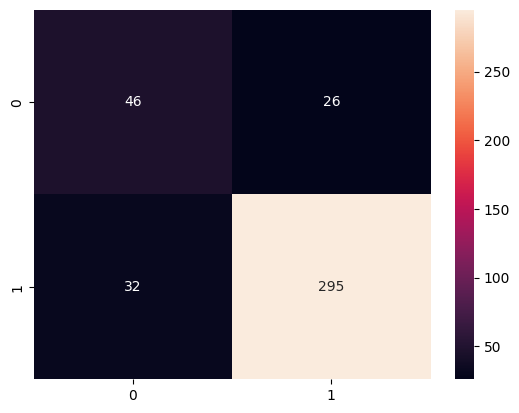

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get the predictions on the validation data
y_pred = model.predict(dataset[1])

# Convert the predictions to binary values
y_pred_binary = (y_pred > 0.5).astype(int)

# Get the true labels from the validation data
y_true = np.concatenate([y for x, y in dataset[1]], axis=0)

# Generate the classification report
report = classification_report(y_true, y_pred_binary)
print(report)

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_true,y_pred_binary),annot = True,fmt='d')

In [9]:
model.save('vgg16')

INFO:tensorflow:Assets written to: vgg16\assets


INFO:tensorflow:Assets written to: vgg16\assets
